### This will be in the prepare module
    _Check for and remove duplicates by customer_id. - None
    
    _Remove redundant columns: payment_type_id, internet_service_type_id, contract_type_id, & customer_id. - Completed
        -Used the following to drop redundant columns
        -df = df.drop(['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], axis = 1)
        -df.head(2)
    
    _Encode payment_type(Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)), internet_service_type(DSL, Fiber, None), contract_type(Month-to-month, One year, Two year), gender(male/female), partner(yes/no), multiple_line(yes/no), device_protection(yes/no), tech_support(yes/no), streaming_tv(yes/no), streaming_movies(yes/no), paperless_billing, & churn (yes/no).
    - gender is male(1) or not male(0)
    - yes(1) no(0)
    - payment, contract and service types (True = 1) (Fales = 0)
    
    _Check for nulls and fill (Fill in total_charges' blanks with 0). - Completed
        -#find empty values. Tried isna, isnull, notna, notnull but did not shown any matches.
            -df.eq(' ').sum()
        -Used .replace to empty values with a 0 in total charges.
            -df = df.replace({'total_charges': ' '}, 0)
            -df.head()

    _Convert total_charges to float64. - Completed
        -#convert 'total_charges' to float and validate change.
        - df['total_charges'] = df['total_charges'].astype(float)
        - df.dtypes
    
    _Replace 'No phone service' & 'No internet service' with 'No'. - Completed
        -df.replace(to_replace = 'No internet service', value = 'No')
        -df.replace(to_replace = 'No phone service', value = 'No')

In [1]:
#libraries
import get_db
import explore
import prepare
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import graphviz
from graphviz import Graph

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Plan

    Goal: Identify feature(s) that cause the greatest churn.
    
    Churn rate is 26.5% (1869) of 7043 customers.
    
    Taking you through the data pipeline I will begin with acquiring the telcor data from the get_db.py module, prepare it using the prepare.py module, split the data and on through exploration. Using explore.py module I identified a set of features used to develop my initial hypothesis. Once cleaned I ran it through multivariate to compare features to help with testing the listed inital hypothesis. Each exploration will include takeaways that have led to preparing, cleaning ant testing of the data resulting in rejecting or failing to reject the final hypothesis.
    
    Features within my hypothesis have been split, tested and modeled in order to provide a recommendation on the final hypothesis in order to reduce churn rates based rejected or failed to reject of the hypothesis. 
    
    I have also identified unknown variables that at a later time can be researched, developed and tested using this model to predict future churn.

    My initial hypothesis are listed below:
    
        1. Customers on fiber are more likely to churn than those customers not on fiber.
            - Null: Customers on fiber are LESS Likely to churn than customers not on fiber.
            - Alternate: Customers on fiber are MORE likely to churn.
            NOTES from univariate TAKEAWAYS:
                *****AND what internet services fiber customers have AND do they affect churn?
                *****What are the monthly costs?
                
        2. Customers are more likely to churn in the first month of service than any other customer.
            - Null: Customers are LESS likely to churn in the first month.
            - Alternate: Customers are MORE likely to churn in the first month.
            
        3. Customers who are NOT senior citizens are more likely to churn than senior citizens.
            - Null: Younger customers are LESS likely to churn than older customers.
            - Alternate: Younger customers are MORE likely to churn than older customers.
            
        4. m2m churn is greater than those customers not on m2m plan.
            - Null: m2m churn is LESS THAN those on contracts.
            - Alternate: m2m churn is GREATER THAN those on contracts.
            
        5. Customers enrolled in automatic payment plan are less likely to churn than those customers not enrolled in the automatic payment plan.
            - Null: Customers enrolled in an autopayment plan are MORE LIKELY to churn than customers not on an autopayment plan.
            - Alternate: Customers on an autopayment plane are LESS LIKELY to churn than customers not on an autopayment plan.
            
        6. Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
            - Null: Customers with phone services are LES LIKELY to churn than those that do not have phone services.
            - Alternate: Customers with phone services are MORE LIKELY to churn than those that do not have phone services.
            
    FEATURES:
    
        *** fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)

    FINAL HYPOTHESIS (reject or fail to reject):

        *** Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        

    Exploration:
        1. Univariate
        2. Bivariate
        3. Multivariate

    Modeling:
        1. Decision Tree
        2. Random Forrest
        3. KNN
        
    Conclusion
        In conclusion, we ran through the data pipeline, identified our initial hypothesis, split, tested and model our features that resulted in the following recommendations.
        1.
        2.
        3.


# *Working code for project*

# Acquire

In [2]:
df = get_db.get_telco_data()
df.head()

,payment_type_id,payment_type,internet_service_type_id,internet_service_type,contract_type_id,contract_type,customer_id,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,1,Electronic check,1,DSL,1,Month-to-month,0015-UOCOJ,Female,1,No,...,Yes,No,No,No,No,No,Yes,48.20,340.35,No
1,1,Electronic check,1,DSL,1,Month-to-month,0023-HGHWL,Male,1,No,...,No,No,No,No,No,No,Yes,25.10,25.1,Yes
2,1,Electronic check,1,DSL,1,Month-to-month,0067-DKWBL,Male,1,No,...,Yes,No,No,No,No,No,Yes,49.25,91.1,Yes
3,1,Electronic check,1,DSL,2,One year,0083-PIVIK,Male,0,No,...,Yes,Yes,Yes,Yes,Yes,No,No,81.25,5567.55,No
4,1,Electronic check,1,DSL,1,Month-to-month,0096-BXERS,Female,0,Yes,...,No,No,No,No,No,No,No,50.35,314.55,No


#### Initial visualization

##### TAKEAWAYS 

    -Related services:
        *multiple_services relates to phone_services
        *online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies related to internet services. 

# Clean/Prepare

    - The prepare file is broke up by sections to identify at which stage of the pipeline that I decided to edit, alter, modify or delete colums, column names, data types, etc...and are identifed by notes within the code.

    * Initial clean up was done just after initial visualization of raw data.
    * all other decisions to modify the dataframe are annotated within the prepare.py module.

In [3]:
#added above to the prepare module.
df = prepare.clean_data(df)
df.head()

,tenure,monthly_charges,fiber,m2m,is_senior,churned,partner,dependents,phone_service,online_security,online_backup,device_protection,tech_support,autopayment
0,7,48.20,0,1,1,0,0,0,1,1,0,0,0,0
1,1,25.10,0,1,1,1,0,0,0,0,0,0,0,0
2,2,49.25,0,1,1,1,0,0,1,1,0,0,0,0
3,64,81.25,0,0,0,0,0,0,1,1,1,1,1,0
4,6,50.35,0,1,0,0,1,0,1,0,0,0,0,0


# Split your data into train, validate, and test samples.

    The resulting dataframes should be 3 samples:
    
        1. a dataframe for training the algorithms
            * The train dataset is for training our models. We also perform our exploratory data analysis on train.
            
        2. a dataframe for validating the models developed on unseen data
            *First, it is an "out of sample" dataset so that we can evaluate our models on unseen data to measure how well the model generalizes.
            *Second, the validate set allows us to fine tune our hyperparameters.
            
        3. a dataframe for testing the best performing model to ensure the model is able to be generalized on a final set of unseen data not 'overfitting' train, a validate and a test, roughly a 70%:20%:10% split
            *final out of sample dataset used to evaluate how well the models tuned on validate generalize on unseen data.

In [4]:
#Split the dataframe into three dataframes (train, validate, and test)
train, validate, test = prepare.train_validate_test_split(df, 'churned')

# Exploratory

    1. Discover features, using  that have the largest impact on the target variable, i.e. provide the most information gain, drive the outcome. To discover patterns, to spot anomalies, to test hypotheses and to check assumptions
        *The dataframe resulting from these functions should be one that is pre-processed, i.e. ready to be used in modeling.
        *attributes are reduced to features, features are in a numeric form, there are no missing values, and continuous and/or ordered values are scaled to be unitless.
        
    2. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable).
    
    3. Use visualization techniques to identify drivers and follow up with a statistical test, do so.
    
    4. Test Hypothesis (t-tests, correlation, chi-square, e.g.)

#### Univariate Stats

    1. Descriptive stats, frequencies, histograms.    
        * Explore the target variable.
        * Explore the categorical/qualitative variables.
        * Explore the continuous/quantitative variables.

In [ ]:
train.shape

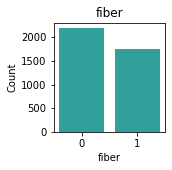

   fiber  Count  Percent
0      0   2191    55.57
1      1   1752    44.43
_________________________________________________________________


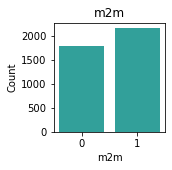

   m2m  Count  Percent
1    1   2160    54.78
0    0   1783    45.22
_________________________________________________________________


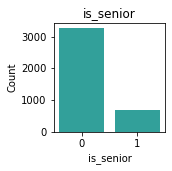

   is_senior  Count  Percent
0          0   3261     82.7
1          1    682     17.3
_________________________________________________________________


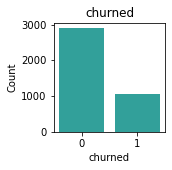

   churned  Count  Percent
0        0   2897    73.47
1        1   1046    26.53
_________________________________________________________________


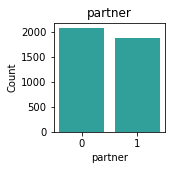

   partner  Count  Percent
0        0   2066     52.4
1        1   1877     47.6
_________________________________________________________________


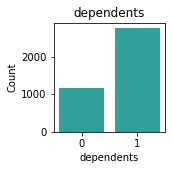

   dependents  Count  Percent
0           1   2763    70.07
1           0   1180    29.93
_________________________________________________________________


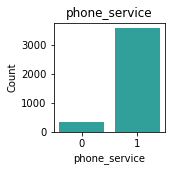

   phone_service  Count  Percent
1              1   3584     90.9
0              0    359      9.1
_________________________________________________________________


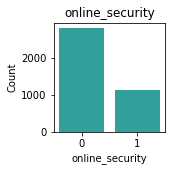

   online_security  Count  Percent
0                0   2812    71.32
1                1   1131    28.68
_________________________________________________________________


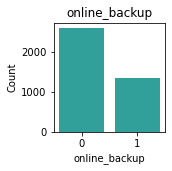

   online_backup  Count  Percent
0              0   2600    65.94
1              1   1343    34.06
_________________________________________________________________


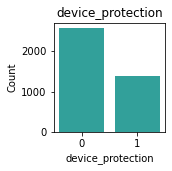

   device_protection  Count  Percent
0                  0   2568    65.13
1                  1   1375    34.87
_________________________________________________________________


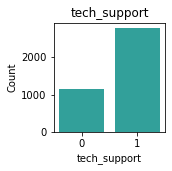

   tech_support  Count  Percent
0             1   2779    70.48
1             0   1164    29.52
_________________________________________________________________


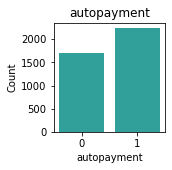

   autopayment  Count  Percent
0            1   2240    56.81
1            0   1703    43.19
_________________________________________________________________


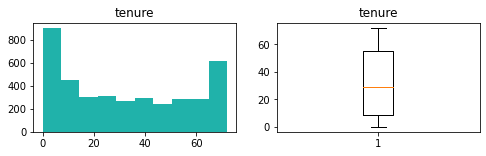

count    3943.000000
mean       32.324372
std        24.569279
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


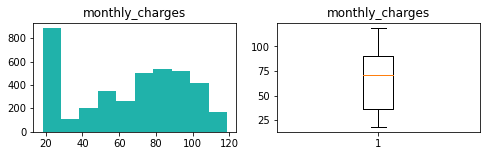

count    3943.000000
mean       65.150710
std        30.030427
min        18.250000
25%        36.475000
50%        70.700000
75%        89.950000
max       118.750000
Name: monthly_charges, dtype: float64


In [5]:
#list all categorical variables and quatintative variables for exploration within the train df.
cat_vars = ['fiber', 'm2m', 'is_senior', 'churned', 'partner', 'dependents', 'phone_service',
           'online_security', 'online_backup', 'device_protection', 'tech_support', 'autopayment']
quant_vars = ['tenure', 'monthly_charges']
#variable histograms
explore.explore_univariate(train, cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021
    - 44.43% (1752) of customers are on fiber
    - 54.78% (2160) of customers are m2m 
    - 82.7% (3261) of customers are not seniors
    - 26.53% (1046) of customers churned
    - is_male is an even distribution. DROPPED this column.
    - Customers with a 'partner' similarly divided (47.6 & 52.6 respectively)
    - Customers with 'dependents' account for 70.1%
    - Customers with 'phone_service_ account' for 91%
    - autopayment accounts for 56.81% (2240) of customers 43.19% (1703) are not on autopayment.
    - phone and internet services will be used at a later time.
    - average tenure 32.32%
    - average monthly_charges 65.15%
    
    -Initial assessment during prepare stage of the pipeline.
        - m2m - 2160 or 55%, 1 year - 811 or 21%, 2 year - 972 or 24%
            *change contract type to m2m (yes or no) and drop one and two year contracts.
            *assumption is that if it is not m2m plan all others are on a contract.
        - payment type - change to autopayment and drop 'credit_card', 'bank_transfer', check' and 'e_check'
        -interent type:
            *change internet type to fiber (Yes or No).
            *Because there was only 61 customers with no internet that churned as validated in the Bivariate stats below.
            *assumption, based on hypothesis, is that a customer is on fiber or not on fiber. 

# Hypothesis Testing

#### Bivariate Stats

    1. Plot the interaction of each variable with the target. 
    
    2. Document takeaways.

    3. Explore interation of independent variables using viz and/or hypothesis testing to address interdependence.

fiber 
_____________________

         chi2       p-value  degrees of freedom
0  363.780774  4.230027e-81                   1

observed:
 churned     0     1   All
fiber                    
0        1873   318  2191
1        1024   728  1752
All      2897  1046  3943

expected:
              0           1
0  1609.770987  581.229013
1  1287.229013  464.770987


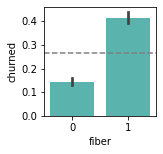


_____________________

m2m 
_____________________

         chi2        p-value  degrees of freedom
0  663.836694  2.187516e-146                   1

observed:
 churned     0     1   All
m2m                      
0        1666   117  1783
1        1231   929  2160
All      2897  1046  3943

expected:
              0           1
0  1310.005326  472.994674
1  1586.994674  573.005326


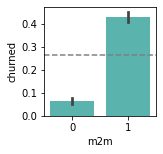


_____________________

is_senior 
_____________________

        chi2       p-value  degrees of freedom
0  90.198518  2.154234e-21                   1

observed:
 churned       0     1   All
is_senior                  
0          2496   765  3261
1           401   281   682
All        2897  1046  3943

expected:
              0           1
0  2395.921126  865.078874
1   501.078874  180.921126


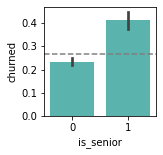


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  99.970619  1.546747e-23                   1

observed:
 churned     0     1   All
partner                  
0        1379   687  2066
1        1518   359  1877
All      2897  1046  3943

expected:
              0           1
0  1517.931017  548.068983
1  1379.068983  497.931017


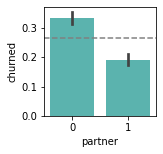


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  104.107639  1.916180e-24                   1

observed:
 churned        0     1   All
dependents                  
0           1900   863  2763
1            997   183  1180
All         2897  1046  3943

expected:
              0           1
0  2030.030687  732.969313
1   866.969313  313.030687


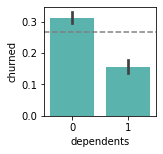


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.001099  0.973553                   1

observed:
 churned           0     1   All
phone_service                  
0               264    95   359
1              2633   951  3584
All            2897  1046  3943

expected:
              0           1
0   263.764393   95.235607
1  2633.235607  950.764393


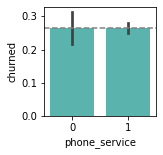


_____________________

online_security 
_____________________

         chi2       p-value  degrees of freedom
0  132.877053  9.618794e-31                   1

observed:
 churned             0     1   All
online_security                  
0                1921   891  2812
1                 976   155  1131
All              2897  1046  3943

expected:
              0           1
0  2066.031955  745.968045
1   830.968045  300.031955


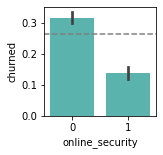


_____________________

online_backup 
_____________________

        chi2       p-value  degrees of freedom
0  33.262971  8.050100e-09                   1

observed:
 churned           0     1   All
online_backup                  
0              1834   766  2600
1              1063   280  1343
All            2897  1046  3943

expected:
              0           1
0  1910.271367  689.728633
1   986.728633  356.271367


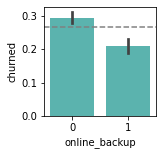


_____________________

device_protection 
_____________________

        chi2       p-value  degrees of freedom
0  26.695574  2.381665e-07                   1

observed:
 churned               0     1   All
device_protection                  
0                  1818   750  2568
1                  1079   296  1375
All                2897  1046  3943

expected:
              0           1
0  1886.760335  681.239665
1  1010.239665  364.760335


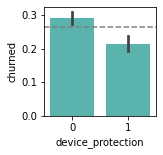


_____________________

tech_support 
_____________________

        chi2       p-value  degrees of freedom
0  96.606082  8.458805e-23                   1

observed:
 churned          0     1   All
tech_support                  
0             1917   862  2779
1              980   184  1164
All           2897  1046  3943

expected:
              0           1
0  2041.786203  737.213797
1   855.213797  308.786203


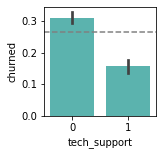


_____________________

autopayment 
_____________________

         chi2       p-value  degrees of freedom
0  182.036408  1.741018e-41                   1

observed:
 churned         0     1   All
autopayment                  
0            1460   780  2240
1            1437   266  1703
All          2897  1046  3943

expected:
              0           1
0  1645.772255  594.227745
1  1251.227745  451.772255


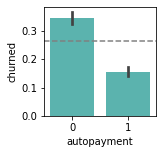


_____________________

tenure 
____________________



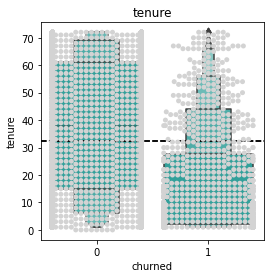

          count       mean        std  min   25%   50%    75%   max
churned                                                            
0        2897.0  37.733517  24.071015  0.0  15.0  38.0  61.00  72.0
1        1046.0  17.343212  19.121415  1.0   2.0   9.0  27.75  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2271196.5, pvalue=5.796579997877841e-127)

____________________

monthly_charges 
____________________



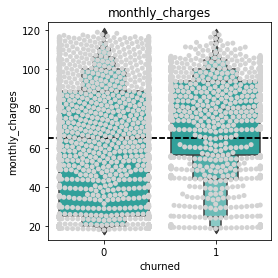

          count       mean        std    min      25%    50%    75%     max
churned                                                                    
0        2897.0  61.850846  31.160324  18.25  25.2000  65.25  89.10  118.75
1        1046.0  74.290010  24.439527  18.95  56.3125  79.55  93.85  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1176266.5, pvalue=6.775715811014378e-27)

____________________



In [6]:
#removed target 'churned'
cat_vars = ['fiber', 'm2m', 'is_senior', 'partner', 'dependents', 'phone_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support', 'autopayment']
quant_vars = ['tenure', 'monthly_charges']
explore.explore_bivariate(train, 'churned', cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021
  -ON ALL Trained data
  
     - Number of fiber (728)  customers who churned.
       * what is about our fiber internet service is making customers churn?
       * Less people churn on DSL (257) then on fiber...possible validation that fiber service needs work.
       * DROP no_internet. Only 61 customers who do not have internet churn.
       HYPOTHESIS: Customers on fiber are more likely to churn than those customers not on fiber. ****convert Fiber and DSL into one column - Fiber(Yes or No) and encode.
       *****AND what internet services fiber customers have AND do they affect churn.
       * The new fiber becomes a feature
       * test hyp

    - 90.5% (929/1231) of customers in the first month churn than any other month
        HYPOTHESIS: Customers are more than likely to churn in the first month of service than any other customer.
        
    - senior_citizen:
        HYPOTHESIS: Customers who are NOT senior citizens (765) are more likely to churn than senior citizens (281).
 
    - Between 'partner' and 'dependents' less single (no_d_863-no_p_687=176) customers churn then not single people (p_359 + d_183 = 542).
    
    - Phone service:
        HYPOTHESIS: Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
            ***DROP multiple_lines. It is evenly weighed and does not have an impact on phone_services.
            
    - Interent services: DROP streaming services. Streaming services are eveningly weighed and will not affect intenert services and churn.
        
    - Payment type:
        * converted payment type to autopayment (Yes or No). Assumption is that customers are either on or not on an autopayment plan.can I call you
        HYPOTHESIS: Customers enrolled in automatic payment plan (266) are less likely to churn than those customers NOT enrolled in the automatic payment plan (780).

    - Lower tenure more churn.
    - Higher monthly payments more churn.

  
    
    - Contract type:
        * combine  m2m, 1, and 2 year contracts to a single column titled 'm2m' and encode.
        HYPOTHESIS: m2m churn is greater than those customers not on m2m plan.
        ---------------------------------------------
    QUESTIONS:
        1. Why do customers on fiber churn more?
        2. Why do customers churn more in the first month than any other month?
        3. Why do non single customers (with partner or dependents) churn more then single customers?
        4. Why do younger customers churn more than older customers?
        5. Why do customers on m2m plans churn more than those customers on contracts?
        6. Why do customers enrolled in autopayments churn less than those customers not enrolled in an autopayment?
        7. Why do customers churn more with phone services?
        
        * What do these questions all have in common?
       ** What is the cost per month of a younger customers who is not single, has phone services and fiber, on a m2m plan, enrolled in an autopayment plan?
       
       *** FINAL HYPOTHESIS: Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        
        MY FEATURES: fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)
        
        Test and validate HYPOTHESIS(reject or fail to reject final hypothesis)
_________________________________________________


Recommendation:???
    _Churn in one month (213)_
        * Incentive...
            - 1 month free service for m2m customers?
            - Free upgrade service for signing a one_year contract?
            - Free premium service for two year contract?
        * Create a graph that shows churn over tenure.

#### Multivariate Stats

    1. How subgroups compare to each-other and to the overall population. 
    
    2. Answer questions using visualizations and/or hypothesis testing.
    
    (Here I can test some of my questions...reference Exploratory Analysis

    _ Need to drop some columns for the multivariate stats.

In [ ]:
target = 'churned'
explore.explore_multivariate(train, target, cat_vars, quant_vars)

##### TAKEAWAYS

# Modeling

### Decision Tree

In [ ]:
#create the model

#for classification you can change the algorithm to gini or entropy (information gain).  
#Default is gini.

model = DecisionTreeClassifier(max_depth=1, random_state=123)

In [ ]:
#Fit the model

model = model.fit(X_train, y_train)

#### Make predictions

In [ ]:
#Use the model

# We'll evaluate the model's performance on train, first

y_predictions = model.predict(X_train)
y_predictions = [0:5]

#### Estimate probability

In [ ]:
y_pred_proba = model.predict_proba(X_train)
y_pred_proba[0:5]

#### Compute accuracy

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(model.score(X_train, y_train)))

#### Confusion matrix

TP
TN
FP
FN

In [ ]:
confusion_matrix(y_train, y_pred)

In [ ]:
y_train.value_counts()

In [ ]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


In [ ]:
print(classification_report(y_train, y_pred))

#### Evaluate the Model with our Validate dataset

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = model.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

In [ ]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

### Random Forrest

In [ ]:
#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [ ]:
#Fit the Model
rf.fit(X_train, y_train)

In [ ]:
#Use the Model
#evaluate the weight
print(rf.feature_importances_)

In [ ]:
#estimate
y_pred = rf.predict(X_train)

In [ ]:
#probability
y_pred_proba = rf.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
#Create a classificaiton report
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_validate, y_validate)))

### KNN

In [ ]:
#Create the model
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
#fit the model
knn.fit(X_train, y_train)

In [ ]:
#predict/use the model
y_pred = knn.predict(X_train)

In [ ]:
#probability
y_pred_proba = knn.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
#validate
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_validate, y_validate)))

# Conclusion

    - What we don't know:
        * How plans relate to cost. i.e. phone to service plans
        * How service plans (online security, online backup, tech support, device protection, and streaming services) relates to cost.
        * Cost of one line, cost of multiple lines (what is multiple lines? Is it 2, 3, 4, or more) and how that relates to cost.

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train.drop(columns=["churned"])
y_train = train.churned

X_validate = validate.drop(columns=["churned"])
y_validate = validate.churned

X_test = test.drop(columns=["churned"])
y_test = test.churned

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train[['fiber','auto_payment']]#features
y_train = train.churned#target

X_validate = validate[['fiber','auto_payment']]
y_validate = validate.churned

X_test = test[['fiber','auto_payment']]
y_test = test.churned

In [ ]:
#Now create the model
model1 = DecisionTreeClassifier(max_depth=3, random_state=123)
#Fit the model
model1.fit(X_train, y_train)
#Use the model
y_predictions = model1.predict(X_train)
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(model1.score(X_train, y_train)))

In [ ]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")